## 对结构化数据进行分类

* 用 Pandas 导入 CSV 文件。
* 用 tf.data 建立了一个输入流水线（pipeline），用于对行进行分批（batch）和随机排序（shuffle）。
* 用特征列将 CSV 中的列映射到用于训练模型的特征。
* 用 Keras 构建，训练并评估模型。

## 数据集
下面是该数据集的描述。 请注意，有数值（numeric）和类别（categorical）类型的列。  
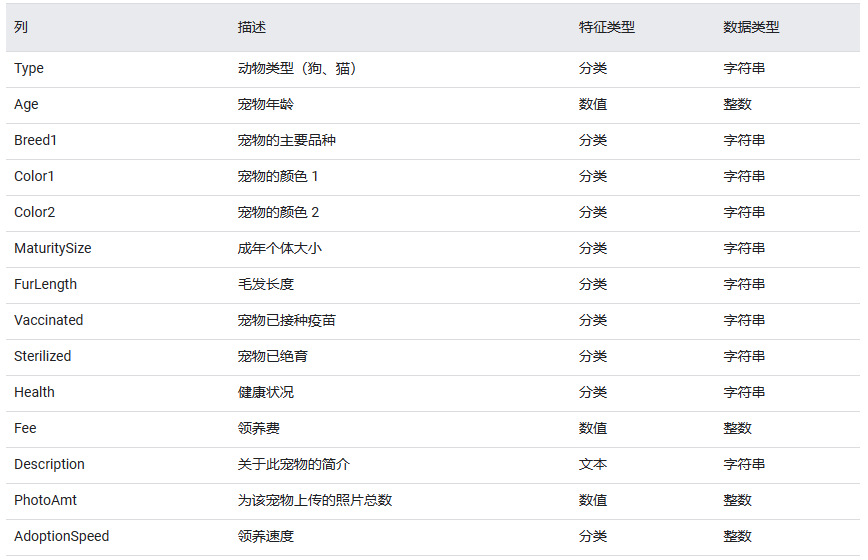

## 导入库


In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## 使用 Pandas 创建一个 dataframe


In [2]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1671168/1668792 [==============================] - 1s 1us/step


In [3]:
# 查看前5个数据
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## 创建目标变量
原始数据集中的任务是预测宠物被领养的速度（例如，在第一周、第一个月、前三个月等）。我们针对教程进行一下简化。在这里，我们将把它转化为一个二元分类问题，并简单地预测宠物是否被领养。

修改标签列后，0 表示宠物未被领养，1 表示宠物已被领养。

In [4]:
# 在原始数据集中，“4”表示该宠物未被收养
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# 删除未使用的列
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

## 将 dataframe 拆分为训练、验证和测试集


In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


## 用 tf.data 创建输入流水线
接下来，我们将使用 tf.data 包装 dataframe。这让我们能将特征列作为一座桥梁，该桥梁将 Pandas dataframe 中的列映射到用于训练模型的特征。如果我们使用一个非常大的 CSV 文件（非常大以至于它不能放入内存），我们将使用 tf.data 直接从磁盘读取它。

In [6]:
# 创建tf的实用程序方法。从Pandas Dataframe获取数据集
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [7]:
batch_size = 5 # 小批量用于演示目的
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## 理解输入流水线
已经创建了输入流水线，让我们调用它来查看它返回的数据的格式。 我们使用了一小批量大小来保持输出的可读性。

In [8]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 8  6 12  2  1], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 1], shape=(5,), dtype=int32)


我们可以看到数据集返回了一个字典，该字典从列名称（来自 dataframe）映射到 dataframe 中行的列值。

## 演示几种特征列
TensorFlow 提供了多种特征列。本节中，我们将创建几类特征列，并演示特征列如何转换 dataframe 中的列。


In [10]:
# 我们将使用这个批来演示几种类型的特性列
example_batch = next(iter(train_ds))[0]
example_batch

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Dog', b'Cat', b'Dog', b'Dog', b'Cat'], dtype=object)>,
 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([11,  2,  2, 48,  1], dtype=int64)>,
 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Beagle', b'Tortoiseshell', b'Mixed Breed', b'Poodle',
        b'Domestic Short Hair'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Female', b'Female', b'Female', b'Female', b'Female'],
       dtype=object)>,
 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Black', b'Brown', b'Brown', b'Cream', b'Black'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Brown', b'Golden', b'No Color', b'No Color', b'Brown'],
       dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Medium', b'Medium', b'Medium', b'Small', b'Small'], dtype=object)>,
 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=array([

In [12]:
# 创建特性列的实用程序方法
# 并对一批数据进行转换
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### 数值列
一个特征列的输出将成为模型的输入（使用上面定义的 demo 函数，我们将能准确地看到 dataframe 中的每列的转换方式）。 数值列（numeric column） 是最简单的列类型。它用于表示实数特征。使用此列时，模型将从 dataframe 中接收未更改的列值。

In [13]:
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[ 2.]
 [11.]
 [ 5.]
 [ 4.]
 [ 1.]]


### 分桶列
通常，您不希望将数字直接输入模型，而是根据数值范围将其值分成不同的类别。考虑代表一个人年龄的原始数据。我们可以用 分桶列（bucketized column）将年龄分成几个分桶（buckets），而不是将年龄表示成数值列。请注意下面的 one-hot 数值表示每行匹配的年龄范围。


In [14]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


### 分类列
在此数据集中，thal 用字符串表示（如 'fixed'，'normal'，或 'reversible'）。我们无法直接将字符串提供给模型。相反，我们必须首先将它们映射到数值。分类词汇列（categorical vocabulary columns）提供了一种用 one-hot 向量表示字符串的方法（就像您在上面看到的年龄分桶一样）。词汇表可以用 categorical_column_with_vocabulary_list 作为 list 传递，或者用 categorical_column_with_vocabulary_file 从文件中加载。

In [15]:
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


### 嵌入列
假设我们不是只有几个可能的字符串，而是每个类别有数千（或更多）值。 由于多种原因，随着类别数量的增加，使用 one-hot 编码训练神经网络变得不可行。我们可以使用嵌入列来克服此限制。嵌入列（embedding column）将数据表示为一个低维度密集向量，而非多维的 one-hot 向量，该低维度密集向量可以包含任何数，而不仅仅是 0 或 1。嵌入的大小（在下面的示例中为 8）是必须调整的参数。

关键点：当分类列具有许多可能的值时，最好使用嵌入列。我们在这里使用嵌入列用于演示目的，为此您有一个完整的示例，以在将来可以修改用于其他数据集。

In [16]:
# 注意，嵌入列的输入是分类列

breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[-0.61992735  0.43354046 -0.3657211  -0.02217631  0.09094315 -0.14921367
   0.20001413 -0.2158108 ]
 [-0.16103405  0.2293462   0.25379077 -0.21365134 -0.23677778 -0.2737417
   0.5228353   0.26123923]
 [-0.27055305  0.1281035  -0.06410974  0.16623133 -0.1869549  -0.2615515
  -0.66646475 -0.20771728]
 [ 0.14549407  0.29467344  0.23482719  0.51017004  0.522354   -0.1989064
  -0.33994097  0.01993669]
 [ 0.24517111  0.4298316   0.17092457  0.2861499   0.6197846   0.26034796
   0.10138234 -0.12795258]]


### 经过哈希处理的特征列
表示具有大量数值的分类列的另一种方法是使用 categorical_column_with_hash_bucket。该特征列计算输入的一个哈希值，然后选择一个 hash_bucket_size 分桶来编码字符串。使用此列时，您不需要提供词汇表，并且可以选择使 hash_buckets 的数量远远小于实际类别的数量以节省空间。

关键点：该技术的一个重要缺点是可能存在冲突，不同的字符串被映射到同一个范围。实际上，无论如何，经过哈希处理的特征列对某些数据集都有效。

In [17]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 组合的特征列
将多种特征组合到一个特征中，称为特征组合（feature crosses），它让模型能够为每种特征组合学习单独的权重。此处，我们将创建一个 age 和 thal 组合的新特征。请注意，crossed_column 不会构建所有可能组合的完整列表（可能非常大）。相反，它由 hashed_column 支持，因此您可以选择表的大小。


In [18]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## 选择要使用的列
已经了解了如何使用几种类型的特征列。 现在我们将使用它们来训练模型。本教程的目标是向您展示使用特征列所需的完整代码（例如，机制）。我们任意地选择了几列来训练我们的模型。

关键点：如果您的目标是建立一个准确的模型，请尝试使用您自己的更大的数据集，并仔细考虑哪些特征最有意义，以及如何表示它们。

In [19]:
feature_columns = []

# 数字列
for header in ['PhotoAmt', 'Fee', 'Age']:
  feature_columns.append(feature_column.numeric_column(header))

In [20]:
# 分桶列
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [21]:
# 分类列
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [22]:
# 嵌入列
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [23]:
# 组合列
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

### 建立一个新的特征层
已经定义了我们的特征列，我们将使用密集特征（DenseFeatures）层将特征列输入到我们的 Keras 模型中。

In [24]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

之前，我们使用一个小批量大小来演示特征列如何运转。我们将创建一个新的更大批量的输入流水线。

In [25]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### 创建、编译和训练模型


In [26]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
231/231 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.6843WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'Breed1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'Gender': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Color1': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'Color2': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'MaturitySize': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'FurLength': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'Vaccinated': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'Sterilized': <tf.Tensor 'ExpandDims_10

In [27]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

73/73 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7491
Accuracy 0.7491334676742554


关键点：通常使用更大更复杂的数据集进行深度学习，您将看到最佳结果。使用像这样的小数据集时，我们建议使用决策树或随机森林作为强有力的基准。本教程的目的不是训练一个准确的模型，而是演示处理结构化数据的机制，这样，在将来使用自己的数据集时，您有可以使用的代码作为起点。

## 参考
https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=zh-cn